In [1]:
import torch
import sbi.utils as utils
from sbi.inference.base import infer

import subprocess

import numpy as np
from matplotlib import pyplot as plt

import corner

from astropy import units as u


/Users/colinburke/miniconda3/envs/sbi_env/lib/python3.8/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


### Toy example of SBI - SAM

 https://sbi-dev.github.io/sbi/install/

 https://astroautomata.com/blog/simulation-based-inference/

In [ ]:
import torch
import sbi.utils as utils
from sbi.inference.base import infer

Priors

In [ ]:
prior = utils.BoxUniform(
    low=torch.tensor([-5., -5.]),
    high=torch.tensor([5., 5.])
)

In [ ]:
def simulator(theta):
    # Generate samples from N(mu, sigma=0.5)
    # Run DARK SAGE with parameters theta

    # Modify the parameter file with theta

    
    subprocess.run(["ls", "-l"])  # Run dark sage [change to dark sage command]

    # Convert the Dark sage output to tensor
    
    return theta + 0.5 * torch.randn_like(theta)

Learn the likelihood from the simulator

In [ ]:
num_sim = 200
method = 'SNRE' #SNPE or SNLE or SNRE
posterior = infer(
    simulator,
    prior,
    # See glossary for explanation of methods.
    #    SNRE newer than SNLE newer than SNPE.
    method=method,
    num_workers=-1,
    num_simulations=num_sim)

### Generate observed distributions

In [3]:
def GSMF(M_star, size=1):
    """
    Galaxy stellar mass function of the z ~ 0 blue+green galaxy population (single Schechter function)
    https://ui.adsabs.harvard.edu/abs/2012MNRAS.421..621B/abstract
    """
    logM_br = 10.78
    dlogM_br = 0.01
    
    phi1 = 2.96*1e-3
    dphi1 = 0.40*1e-3
    
    phi2 = 0.63*1e-3
    dphi2 = 0.10*1e-3
    
    alpha1 = -0.62
    dalpha1 = 0.03
    
    alpha2 = -1.50
    dalpha2 = 0.01
    
    M_br = 10**np.random.normal(loc=logM_br, scale=dlogM_br, size=size)*u.Msun
    phi1 = np.random.normal(loc=phi1, scale=dphi1, size=size)*u.Mpc**-3
    
    phi2 = np.random.normal(loc=phi2, scale=dphi2, size=size)*u.Mpc**-3
    
    alpha1 = np.random.normal(loc=alpha1, scale=dalpha1, size=size)
    alpha2 = np.random.normal(loc=alpha2, scale=dalpha2, size=size)

    phi = np.exp(-M_star/M_br)/M_br * (phi1*(M_star/M_br)**alpha1 + phi2*(M_star/M_br)**alpha2)

    #phi = np.exp(-M_star[:, np.newaxis]/M_br)/M_br * (phi1*(M_star[:, np.newaxis]/M_br)**alpha1 + phi2*(M_star[:, np.newaxis]/M_br)**alpha2)
    #phi = np.exp(-M_star/M_br)/M_br * (phi1*(M_star/M_br)**alpha1 + phi2*(M_star/M_br)**alpha2)

    return phi

In [48]:
def inv_transform_sampling(y, x, n_samples=1000):
    """
    Perform inverse transform sampling on curve y(x)
    https://tmramalho.github.io/blog/2013/12/16/how-to-do-inverse-transformation-sampling-in-scipy-and-numpy/
    https://en.wikipedia.org/wiki/Inverse_transform_sampling
    """
    dx = np.diff(x)
    cum_values = np.zeros(x.shape)
    cum_values[1:] = np.cumsum(y*dx)/np.sum(y*dx)
    r = np.random.rand(int(n_samples))
    return np.interp(r, cum_values, x)

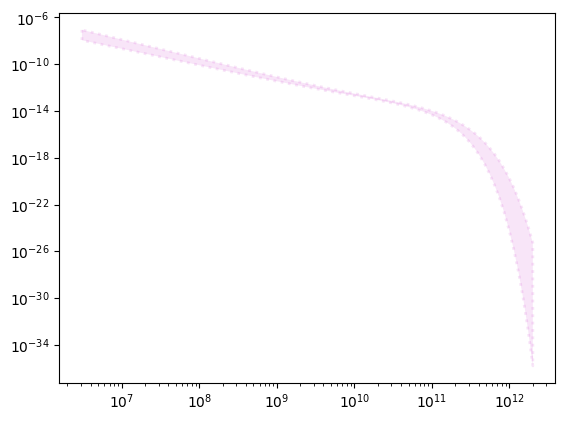

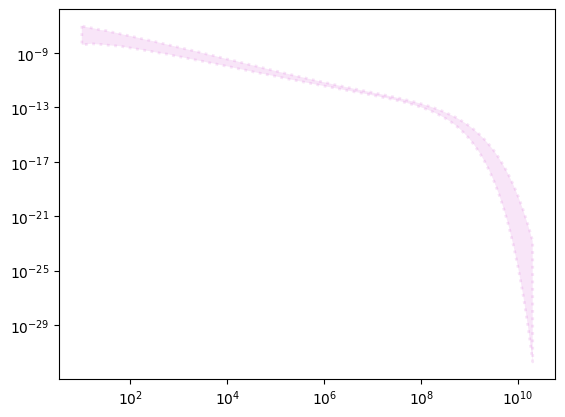

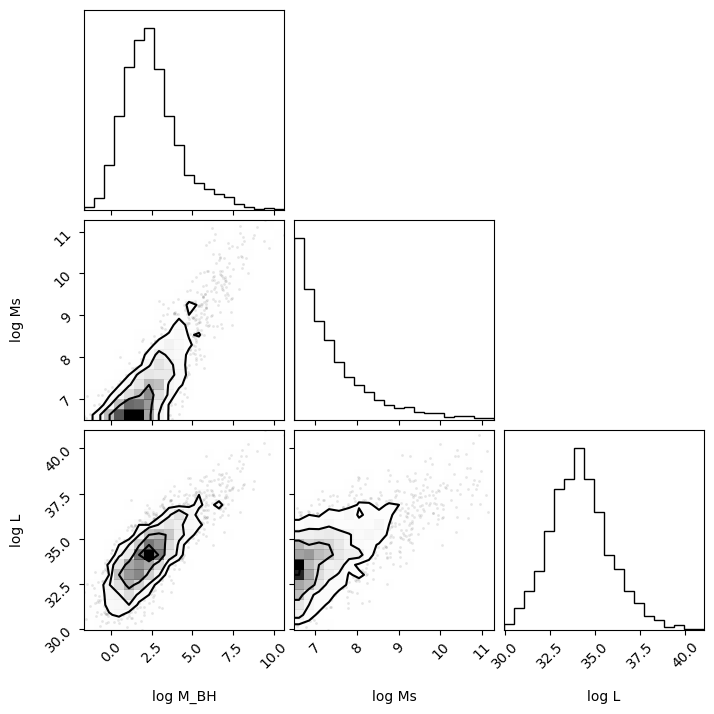

In [65]:
dlogmb =  0.1
logmb = np.arange(1.0, 10.5, dlogmb)
mb = 10**logmb

shape = [len(logmb), 2000]

# BH - stellar mass relation
# GSH20, All, limits
alpha = np.random.normal(7.43, 0.09, size=shape[1])
beta = np.random.normal(1.61, 0.12, size=shape[1])
sigma = np.random.normal(0.81, 0.06, size=shape[1])
logms0 = np.log10(3*1e10)

logms = logms0 + (logmb[:, np.newaxis] - alpha.T)/beta.T
ms = 10**logms
_ms = np.median(ms, axis=1)
dms = np.diff(ms, axis=0)

# Sample the "observations" from the GSMF
gsmf = GSMF(ms*u.Msun, size=shape[1]).value

plt.fill_between(ms[:,0], np.percentile(gsmf, 16, axis=1), np.percentile(gsmf, 84, axis=1),
                color="m", alpha=0.1, zorder=-1, label='this work', lw=2, ls='dotted')
plt.loglog()
plt.show()

dist_stellar_mass = inv_transform_sampling(np.percentile(gsmf[:-1,:], 50, axis=1), ms[:,0], shape[1])
dist_log_stellar_mass = np.log10(dist_stellar_mass)

# Sample the "observations" from the BHMF
# Assuming occupation fraction of 1

# Plot BHMF
N = np.random.normal(loc=alpha.T + beta.T*(logms - logms0), scale=sigma)
bhmf_1 = (gsmf * N)[:-1,:] #

plt.fill_between(mb[:-1], np.percentile(bhmf_1, 16, axis=1), np.percentile(bhmf_1, 84, axis=1),
                color="m", alpha=0.1, zorder=-1, label='this work', lw=2, ls='dotted')
plt.loglog()
plt.show()

#TODO: sample w/ errors on BHMF
dist_log_bh_mass = np.random.normal(loc = alpha + beta*(dist_log_stellar_mass.T - logms0), scale=sigma)

# Sample the "observations" from the BHLF

# BH mass - L_X relation
alpha = np.random.normal(39.25, 0.2, size=shape[1])
beta = np.random.normal(0.8, 0.05, size=shape[1])
sigma = np.random.normal(0.9, 0.05, size=shape[1])
logms0 = 10

# bolometric correction of 10
dist_log_l_bol = 1 + np.random.normal(loc = alpha + beta*(dist_log_bh_mass.T - logms0), scale=sigma)

# Plot the "observed" posterior
observation = torch.tensor([dist_log_bh_mass, dist_log_stellar_mass, dist_log_l_bol]).T
corner.corner(observation.numpy(), labels=['log M_BH', 'log Ms', 'log L']);


In [67]:
observation[0] # An observation of a single BH

tensor([ 4.3930,  8.7400, 36.9448], dtype=torch.float64)

In [ ]:
samples = posterior.sample((200,), x=observation[0])

In [ ]:
log_probability = posterior.log_prob(samples, x=observation[0])
corner.corner(samples.numpy());